In [1]:
import lsst.daf.persistence as dafPersist
import lsst.analysis.deblender as deblender
import lsst.afw.display as afwDisplay

disp1  = afwDisplay.Display(1)
disp2 = afwDisplay.Display(2)

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)

In [2]:
import os

if "SUPRIME_DATA_DIR" not in os.environ:
    os.environ["SUPRIME_DATA_DIR"] = "/datasets/hsc/repo"
        
dataPath = os.path.join(os.environ["SUPRIME_DATA_DIR"], "rerun", "private", "hchiang2", "RC", "DM-10084-multiband")

butler = dafPersist.Butler(dataPath)
skymap = butler.get("deepCoadd_skyMap")

### Read some data

In [3]:
dataId = dict(tract=8766, patch='2,1', filter='HSC-I')

coadd = butler.get("deepCoadd_calexp", dataId, immediate=True)

ss = butler.get('deepCoadd_meas', dataId)
families = deblender.Families(ss, butler, nChildMin=0)

### Display it

In [4]:
if True:
    disp1.mtv(coadd, title="%(tract)s %(patch)s" % dataId)
else:
    disp1.erase()
    disp1._xy0 = coadd.getXY0()

with disp1.Buffering():
    for s in ss:
        disp1.dot('+' if s['deblend_nChild'] > 0 else 'x',
                  *s.getCentroid(), size=3, ctype=afwDisplay.RED)

### You only need to set these dicts to make 'r' work as a callback to show RGB images of blends

In [4]:
for bandName in "GRI":
    filterName = "HSC-%s" % bandName.upper()
    
    deblender.coaddDict[filterName] = butler.get("deepCoadd_calexp", dataId, filter=filterName)
    sources = butler.get('deepCoadd_meas', dataId, filter=filterName)
    deblender.familiesDict[filterName] = deblender.Families(sources, butler, nChildMin=0)

### Show the deblended families

Put us into a loop waiting on the display.  Sigh.

Live keys in display window:
-  d on an object in frame frame to show the children in display
-  l  Toggle various useful stretches for the children
-  r  Display RGB mosaic of children in notebook (you must have run previous cell)
-  1 2 3 4  Zoom levels for children
-  q to quit the interactive loop

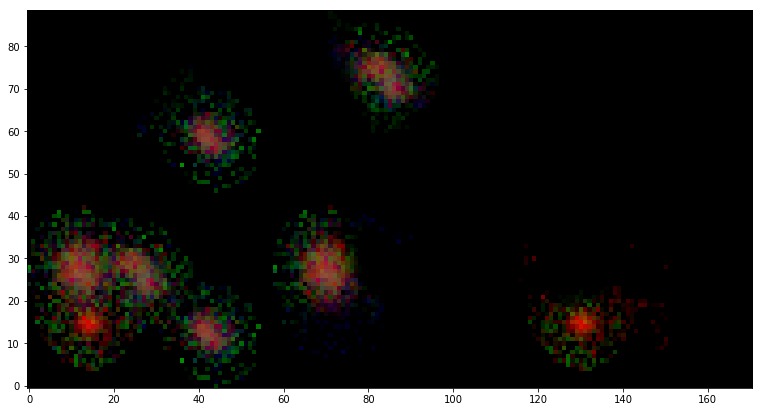

In [5]:
deblender.showBlend(coadd, families, display=disp2, imageDisplay=disp1)

### Here's how to take ra, dec and get (tract, patch)

In [7]:
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord

def decimalRaDec(raStr, decStr):
    """Convert ra, dec as strings to decimals.
    A leading sign for the dec field is optional

    E.g. decimalRaDec("09:59:21.76", "+02:06:38.4")
    """
    ra, dec = raStr.split(':'), decStr.split(':')
    if dec[0][0] in "-+":
        decSign = +1 if dec[0][0] == '+' else -1
        dec[0] = dec[0][1:]
    else:
        decSign = +1

    d, m, s = [float(_) for _ in dec]
    dec = decSign*(d + (m + s/60.0)/60.0)

    h, m, s = [float(_) for _ in ra]
    ra = 15*(h + (m + s/60.0)/60.0)

    return ra, dec

ra, dec = [#("09:59:21.76", "+02:06:38.4"),
           ("22:20:12.83", "+01:20:23.7"),
           ("02:15:19.24", "-03:48:11.1"),
           ("02:28:41.53", "-05:00:05.4"),
           ("22:16:08.70", "+00:55:39.1"),
           ("22:24:25.92", "+01:21:21.7"),
           ][0]
ra, dec = decimalRaDec(ra, dec)
    
raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)
tractInfo, patchInfo = skymap.findClosestTractPatchList([raDec])[0]

dataId = dict(tract = tractInfo.getId(),
              patch = "%d,%d" % patchInfo[0].getIndex(),
              filter='HSC-Z')

print dataId["tract"], dataId["patch"]

9695 3,7


### Playground